In [1]:
import inspect
import networkx as nx
import matplotlib.pyplot as plt
import supergraph
import supergraph.evaluate as eval
import supergraph.paper as paper

In [3]:
# To view algorithm code
# print(inspect.getsource(paper.algorithm_1))
# print(inspect.getsource(paper.algorithm_2))

Generate graphs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 21931.00it/s]


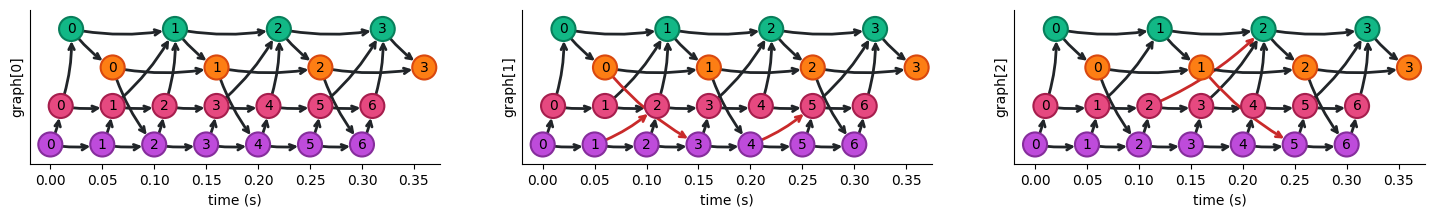

In [3]:
# Generate three example computation graphs
G0, G1, G2 = paper.get_example_graphs()
Gs = [G0, G1, G2]

# Visualize computation graphs
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=[6, 6])
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 2])
for i, (ax, G) in enumerate(zip(axes, Gs)):
    ax.set(ylabel=f"graph[{i}]", xlabel=f"time (s)", xlim=[-0.02, 0.375], ylim=[-0.5, 3.5])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    eval.plot_graph(G, ax=ax)

Growing supergraph: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1438.79it/s, 3/3 graphs, 63/66 matched (87.50% efficiency, 6 nodes)]


[Text(0.5, 0, ''), [], Text(0.5, 1.0, 'Supergraph S')]

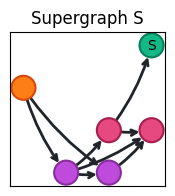

In [6]:
# Find the Minimum Common Supergraph (S) and mappings (Ms) to the corresponding partitions (Ps)
S, Ms, Ps = paper.algorithm_1(supervisor="agent", backtrack=3, Gs=Gs, max_topo=1, max_comb=1)

# IMPORTANT! paper.algorithm_1(...) is optimized for readability, instead of speed.
# Use supergraph.grow_supergraph(...) instead if speed is important
S_opt, _, _ = supergraph.grow_supergraph(Gs, "agent", backtrack=3)

# Visualize supergraph
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[2, 2])
eval.plot_graph(S, draw_labels=True, ax=ax)
ax.set(xlabel="", xticks=[], title=f"Supergraph S")

AttributeError: 'Axes' object has no attribute 'edges'

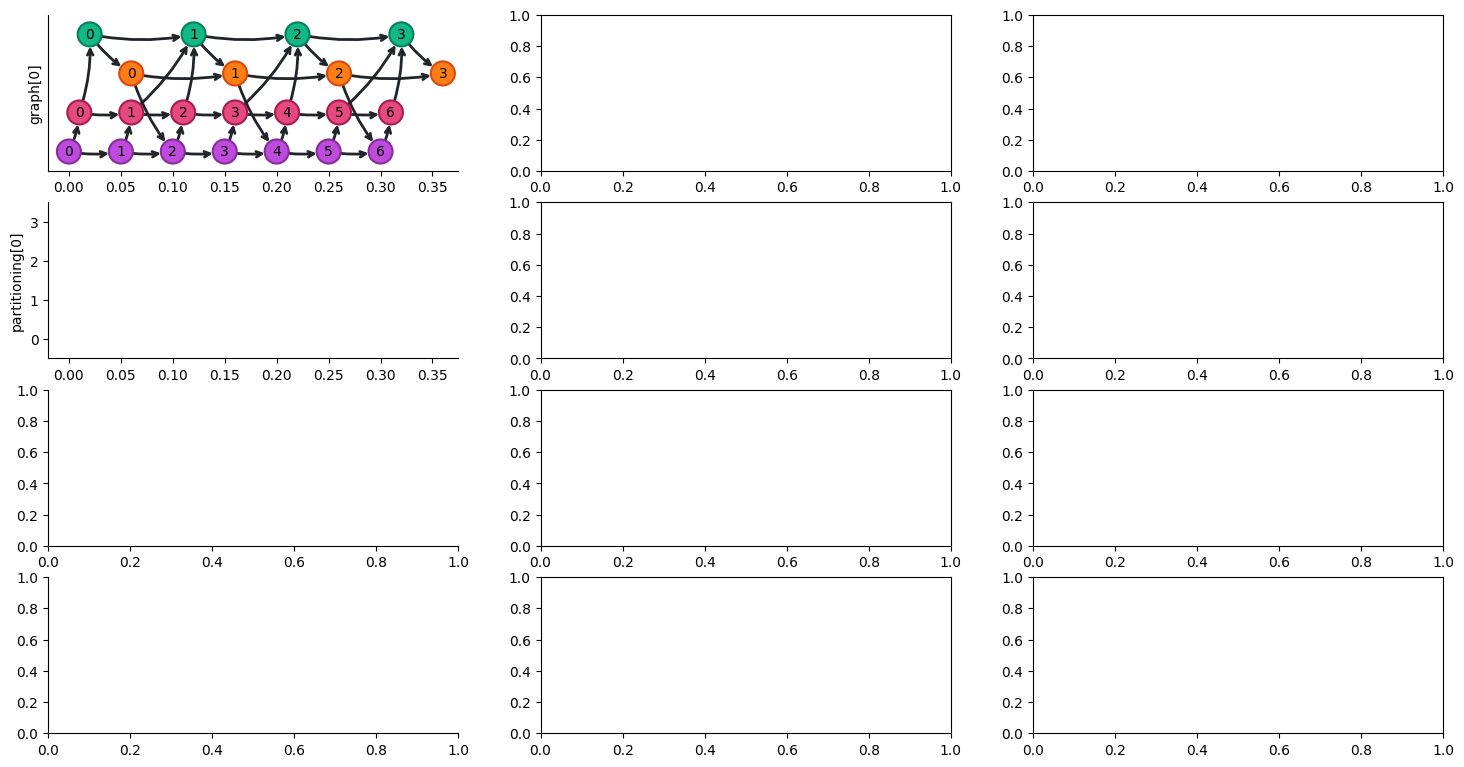

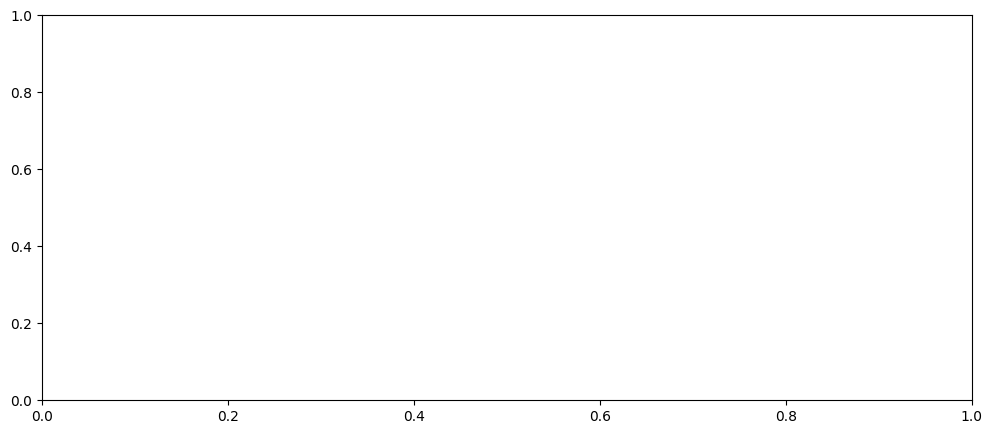

In [7]:
# Visualize graphs, partitioning, subgraph monomorphisms
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=[18, 9.33])
# fig.suptitle(f"Subgraph monomorphism M[{i}][j] maps P[{i}][j] to a subgraph of S")

# Plot graphs
for i in range(len(Gs)):
    G = Gs[i]
    axes[0, i].set(ylabel=f"graph[{i}]", xlabel=f"", xlim=[-0.02, 0.375], ylim=[-0.5, 3.5])
    eval.plot_graph(G, ax=axes[0, i])
    
    for ax in axes[:, i]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
    
    # Plot partitions
    for j in range(len(Ms[i])):
        axes[1, i].set(ylabel=f"partitioning[{i}]", xlabel=f"", xlim=[-0.02, 0.375], ylim=[-0.5, 3.5])
        eval.plot_graph(axes[1, i])
    
    # Plot subgraph monomorphisms
    depth = len(list(nx.topological_generations(S)))
    M_full = {}
    G_full = nx.DiGraph()
    for j in range(len(Ms[i])):
        M = Ms[i][j]
        P = Ps[i][j]
        axes[2, i].set(ylabel=f"monomorphisms[{i}]", yticks=[], xlabel="", xticks=[])
        S_cp = S.copy()
    
        # Determine position and make ununsed edges & nodes transparant
        M_rev = {v: k for k, v  in M.items()}  # Reverse mapping
        for n, data in S_cp.nodes(data=True):
            data["position"] = (data["position"][0]+depth*j, data["position"][1])
            if n in M_rev:
                data["seq"] = P.nodes[M_rev[n]]["seq"]
            else:
                data["alpha"] = 0.2
        for u, v, data in S_cp.edges(data=True):
            if u not in M_rev or v not in M_rev:
                data["alpha"] = 0.2
            elif (M_rev[u], M_rev[v]) not in P.edges():
                data["alpha"] = 0.2
            else:
                data["color"] = P.edges[(M_rev[u], M_rev[v])]["color"]
        eval.plot_graph(S_cp, ax=axes[2, i])

        for u, data in S_cp.nodes(data=True):
            G_full.add_node(f"{j}_{u}", **data)
            if u in M_rev:
                M_full[M_rev[u]] = f"{j}_{u}"
        for u, v, data in S_cp.edges(data=True):
            G_full.add_edge(f"{j}_{u}", f"{j}_{v}", **data)

    for u, v, data in G.edges(data=True):
        if u in M_full and v in M_full:
            if (M_full[u], M_full[v]) not in G_full.edges():
                new_data = {k: v for k, v in eval.edge_data.items()}
                new_data.update({"color": data["color"], "linestyle": "-", "alpha": 1.0})
                G_full.add_edge(M_full[u], M_full[v], **new_data)
    axes[3, i].set(ylabel=f"graph[{i}] built with S", yticks=[], xlabel="", xticks=[])
    eval.plot_graph(G_full, ax=axes[3, i])
